In [1]:
import sys
sys.path.append('../')
from utility.file_utility import FileUtility

# Running DiMotif step-by-step

<img src="../DiMotif.pdf">

Files containing positive and negative sequences (a sequence per line)

In [2]:
# training file
pos_train_file='../datasets/biofilm/pos_train.txt'
neg_train_file='../datasets/biofilm/neg_train.txt'


# testing file
pos_test_file='../datasets/biofilm/pos_test.txt'
neg_test_file='../datasets/biofilm/neg_test.txt'

In [4]:
# load positive and negative sequences
pos_seqs=FileUtility.load_list(pos_train_file)
neg_seqs=FileUtility.load_list(neg_train_file)

# prepare labels and sequences
seqs=[seq.lower() for seq in pos_seqs+neg_seqs]
labels=[1]*len(pos_seqs)+[0]*len(neg_seqs)

## (i) Sequence segmentation

The segmentation can be applied based on the segmentation learned from Swiss-Prot database (general-purpose) or from the positive set (domain-specific)

### Swiss-Prot Segmentation

We need to load the alpha distribution for segmentation sampling from the file.

In [9]:
import scipy.stats as st
import numpy as np
import tqdm
from utility.math_utility import normalize_mat


swiss_size_change=FileUtility.load_obj('data_config/swiss_1000_samples.pickle')
all_samples=[]
for i in tqdm.tqdm(range(0,1000)):
    sample=[]
    for vocab in np.arange(10000,1000000,10000):
        sample.append(swiss_size_change[vocab][i])
    all_samples.append(-np.diff(sample))

sample_mat=np.mean(normalize_mat(all_samples),axis=0)
sample_mat_std=np.std(normalize_mat(all_samples),axis=0)
alpha_param = st.alpha.fit(sample_mat)

100%|██████████| 1000/1000 [00:00<00:00, 11231.20it/s]
/mounts/Users/student/asgari/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2306: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


Then we sample from the alpha distribution:

In [14]:
# number of segmentation to be used

segmentation_schemes=10
r = st.alpha.rvs(alpha_param[0], size=segmentation_schemes)
vocab_sizes=np.array(np.round(10000+(r*10000)),dtype=np.int32).tolist()
vocab_sizes.sort()

In [15]:
# vocabulary sizes seen from Swiss-Prot
vocab_sizes

[14136, 14948, 15082, 15325, 15521, 17459, 19156, 21441, 21482, 47875]

In this step we perform segmentation of the sequences based on the steps we have trained already on Swiss-Prot

In [17]:
from make_representations.cpe_apply import CPE

segmented_seqs=[]
for i, vocab in tqdm.tqdm(enumerate(vocab_sizes)):
    f=open('data_config/swissprot_ppe','r')
    CPE_Applier=CPE(f,separator='', merge_size=vocab)
    for idx, seq in enumerate(seqs):
        if i ==0:
            segmented_seqs.append([CPE_Applier.segment(seq)])
        else:
            segmented_seqs[idx]+=[CPE_Applier.segment(seq)]
extended_sequences=[' '.join(l) for l in segmented_seqs]
possible_segmentations=['@@@'.join(l) for l in segmented_seqs]

10it [19:54, 119.45s/it]


## An example of sequence probablistic segmentation

In [38]:
#Sample segmentations: 
seqs[10]   

'mssklvlvlncgssslkfaiidavngeeylsglaecfhlpearikwkmdgnkqeaalgagaahsealnfivntilaqkpelsaqltaighrivhggekytssvvidesviqgikdaasfaplhnpahligieealksfpqlkdknvavfdtafhqtmpeesylyalpynlykehgirrygahgtshfyvtqeaakmlnkpveelniitchlgnggsvsairngkcvdtsmgltpleglvmgtrsgdidpaiifhlhdtlgmsvdainklltkesgllgltevtsdcryvednyatkedakramdvychrlakyigaytalmdgrldavvftggigenaamvrelslgklgvlgfevdhernlaarfgksgfinkegtrpavviptneelviaqdasrlta'

In [40]:
#View its possible segmentation

for x in possible_segmentations[10].split('@@@'):
    print(x)
    print('-----------------------')

mss klvl vln cg sssl kf ai idav ngee yls glae cf hlpe arik wkm dg nk qe aalg agaa hse al nf ivn til aq kp els aql taig hri vh gge ky tss vvid es vi qg ik daa sf apl hnp ahl ig iee alks fp qlkd kn vav fd taf hqt mp ees yl yal py nl yke hg irr yg ahg ts hfy vt qeaa kml nkp veel niit c hlg n ggs vsai rng kc vdts mgl tple gl vmg tr sgd idp ai if hl hd tlg ms vdai nkll tke sg llgl tevt sd cry ved ny at ked ak ram dvy ch rlak yig ay tal mdg rld av vf tgg igen aa mvr el slg klg vlg fe vd he rnl aar fg ksg fin keg tr pav vi pt neel vi aqd asrl t a
-----------------------
mss klvl vln cg sssl kf ai idav ngee yls glae cf hlpe arik wkm dg nk qe aalg agaa hse al nf ivn til aq kp els aql taig hri vh gge ky tss vvid es vi qg ik daa sf apl hnp ahl ig iee alks fp qlkd kn vav fd taf hqt mp ees yl yal py nl yke hg irr yg ahg ts hfy vt qeaa kml nkp veel niit c hlg nggs vsai rng kc vdts mgl tple gl vmg tr sgd idp ai if hl hd tlg ms vdai nkll tke sg llgl tevt sd cry ved ny at ked ak ram dvy ch rlak yig ay 

## (ii) Discriminative Motif discovery

We set the output directory to be 'biofilm_test_general_purpose'

In [42]:
# to ensure the output path exists
output_path='biofilm_test_general_purpose/'
FileUtility.ensure_dir(output_path)

Using Chi-square test we find the most significant motifs related to the positive class

In [45]:
from chi2analysis.chi2analysis import Chi2Analysis
from sklearn.feature_extraction.text import TfidfVectorizer

# top 100 motifs
topn=100

cpe_vectorizer = TfidfVectorizer(use_idf=False, analyzer='word',
                                              norm=None, stop_words=[], lowercase=True, binary=False, tokenizer=str.split)

tf_vec=cpe_vectorizer.fit_transform(extended_sequences)
vocab=cpe_vectorizer.get_feature_names()
CH=Chi2Analysis(tf_vec,labels,vocab)
vocab_binary=[(x[0],x[2]) for x in CH.extract_features_fdr(output_path+'/motifs.txt', N=topn, alpha=5e-2, direction=True, allow_subseq=True, binarization=True, remove_redundant_markers=False) if x[1]>0]


In [51]:
print ('motif','\t', 'p-value')
print ('=====================')
for motif, pval in vocab_binary:
    print (motif,'\t', pval)

motif 	 p-value
mgl 	 3.521930682092904e-31
vrar 	 9.902697564084905e-29
nae 	 5.566922856242352e-19
madl 	 5.3042577150669156e-17
mgls 	 1.2736500765819503e-16
glp 	 6.698970197443071e-16
flrq 	 7.405817981330542e-16
dav 	 3.216655474412945e-14
tvs 	 1.00523510020983e-13
tiaa 	 1.061556354502781e-12
cgsp 	 1.2234724458461001e-12
rdlkpe 	 1.2234724458461001e-12
yvml 	 1.2234724458461001e-12
klyd 	 2.1663742279409084e-12
ipfe 	 4.135754998644769e-12
pevd 	 5.745774966959567e-12
ylvd 	 1.2044704028248266e-11
mat 	 1.6587840673297503e-11
fgls 	 1.819041449131975e-11
tlaa 	 1.9967033878863413e-11
kivh 	 3.18900359413313e-11
plvp 	 3.7852415451479775e-11
elav 	 7.746816465286166e-11
aape 	 1.3687966275799393e-10
kiin 	 1.3687966275799393e-10
nifl 	 1.7456453075072336e-10
qai 	 2.5017076071493365e-10
glpf 	 3.144739037298401e-10
mtdg 	 5.57665361597382e-10
mtt 	 8.715723706593248e-10
nrit 	 2.1046344671883555e-09
reis 	 3.4591258997340897e-09
flhl 	 5.185679135769597e-09
kvkl 	 5.53288665375

## (iii)  Motif visualizations

### Co-occurrences of motifs

Then we look at the co-occurrences pattern of the motifs on the positve set

In [55]:
from utility.math_utility import get_sym_kl_rows
from clustering.hierarchical import HierarchicalClutering

idxs=[vocab.index(v[0]) for v in vocab_binary]
pos_matrix=tf_vec.toarray()[0:len(pos_seqs),idxs]

# it saves the co-occurance matrix in the output directory and sym_KL.pickle
DIST=get_sym_kl_rows(pos_matrix.T)
FileUtility.save_obj(output_path+'/sym_KL', DIST)

/mounts/Users/student/asgari/.local/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:298: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='complete', metric='euclidean')


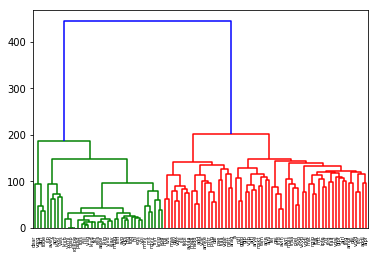

In [57]:
HC=HierarchicalClutering(DIST,[x[0] for x in vocab_binary])
motifs=vocab_binary
tree=HC.nwk

In [59]:
# tree of motifs
HC.nwk

'((((((((((alpf:95.42,addl:95.42):20.06,(fltr:77.15,vrvd:77.15):38.32):4.66,(dai:95.95,amgl:95.95):24.19):2.55,(((((fltq:99.90,airl:99.90):7.23,glpf:107.13):2.15,vdal:109.28):7.95,(tlaa:98.01,flrq:98.01):19.23):1.61,(((nif:88.13,ipfe:88.13):16.11,mtt:104.24):8.94,((ttai:72.80,ngip:72.80):20.87,mat:93.67):19.50):5.68):3.84):9.33,(vddl:76.00,vkvp:76.00):56.01):6.95,((((kvp:49.60,plel:49.60):36.85,traa:86.45):7.68,mgls:94.13):10.26,avrl:104.39):34.58):5.01,(((avin:41.05,trid:41.05):31.67,qai:72.72):14.79,fel:87.51):56.46):4.50,((((ainl:102.59,arie:102.59):7.05,(tam:90.02,mskt:90.02):19.62):6.00,((arve:81.15,aitl:81.15):11.38,(vrip:77.88,glp:77.88):14.65):23.11):13.55,((ggfp:56.80,nifl:56.80):49.18,a:105.98):23.21):19.28):52.55,(((((arag:86.46,nett:86.46):28.50,vqar:114.96):12.49,(tiaa:102.94,nae:102.94):24.51):8.55,(((((daf:54.51,plvp:54.51):22.79,mltr:77.29):19.39,amke:96.68):3.95,vrar:100.63):12.12,((add:52.01,nadd:52.01):26.00,madl:78.00):34.75):23.26):5.94,((((avlaa:73.78,fepl:73.78):

### Visualization of co-occurence pattern

In [64]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

def create_mat_plot(mat, axis_names, title, filename, xlab, ylab, cmap='Blues', filetype='pdf', rx=0, ry=0, font_s=10, annot=True):
    '''
    :param mat: divergence matrix
    :param axis_names: axis_names
    :param title
    :param filename: where to be saved
    :return:
    '''
    plt.rc('text', usetex=True)
    if len(axis_names)==0:
        ax = sns.heatmap(mat,annot=annot, cmap=cmap,fmt="d")
    else:
        # removed fmt="d",
        ax = sns.heatmap(mat,annot=annot, yticklabels=axis_names, xticklabels=axis_names, cmap=cmap)
    plt.title(title)
    params = {
        'legend.fontsize': font_s,
        'xtick.labelsize': font_s,
        'ytick.labelsize': font_s,
        'text.usetex': True,
    }
    matplotlib.rcParams['mathtext.fontset'] = 'stix'
    matplotlib.rcParams['font.family'] = 'STIXGeneral'
    matplotlib.rcParams['mathtext.fontset'] = 'custom'
    matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
    matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
    matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.xticks(rotation=rx)
    plt.yticks(rotation=ry)
    plt.rcParams.update(params)
    plt.tight_layout()
    plt.savefig(filename + '.'+filetype)
    plt.show()
    plt.clf()

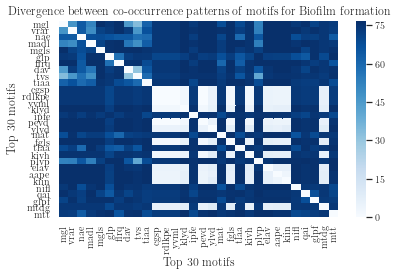

In [67]:
create_mat_plot(DIST[0:30,0:30], [x[0] for x in motifs[0:30]],'Divergence between co-occurrence patterns of motifs for Biofilm formation','Biofilm formation','Top 30 motifs','Top 30 motifs',annot=False, rx=90)

## Adding annotations related to secondary structure and other properties

In [68]:
from proteinseq_util.motif_properties import MotifProperties

In [71]:
MotifPropVis=MotifProperties()

In [74]:
# get most probable structure of this motif in the PDB sequences
MotifPropVis.getMotifStructure('mgl')
#H = alpha helix
#B = residue in isolated beta-bridge
#E = extended strand, participates in beta ladder
#G = 3-helix (3/10 helix)
#I = 5 helix (pi helix)
#T = hydrogen bonded turn
#S = bend
#N = loop or other irregular structure

[('hhh', 0.25),
 ('nnn', 0.19),
 ('ttn', 0.19),
 ('eee', 0.12),
 ('htn', 0.08),
 ('hnn', 0.07),
 ('snn', 0.04),
 ('nee', 0.02),
 ('nsn', 0.02),
 ('tts', 0.02)]

In [78]:
sec_classes,prop=MotifPropVis.get_motifs_pss_biophys(['mgl'])

100%|██████████| 1/1 [00:00<00:00, 1959.96it/s]


In [79]:
prop
# The order is the normalized
#['mean_molecular_weight',
# 'mean_flexibility',
# 'instability',
# 'mean_surface_accessibility',
# 'mean_kd_hydrophobicity',
# 'mean_hydrophilicity']

{'mgl': [-1.0114634864612668,
  -0.28252406036752725,
  -0.28258896805474465,
  -0.970740175139044,
  0.7751299216012043,
  -0.4360941592403529]}

#### if you have ete3 installed you can get the tree visualization as well

In [ ]:
from proteinseq_util.motif_tree_visualization import VisualizeTreeOfMotifs

In [ ]:
VT=VisualizeTreeOfMotifs(tree,[x[0] for x in motifs])

VT.create_circle(output_path+'/biofilm_prop.pdf', 'BioFilm tree of motifs', ignore_branch_length=True)

<img src="biofilm_prop.pdf">